# Test Surrogates

In [ ]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=10,
    train_path="data/branin/data_%i_train.csv" % 10,
    train_fraction=1.0,
    float_precision=64,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper()
candidate_set, xi, yi = dataset_handler.get_candidate_set()
sample_states, _ = dataset_handler.train_data[:]


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f28e06a8d00>>
Traceback (most recent call last):
  File "/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
from activelearning.surrogate.gp_surrogate import SingleTaskGPRegressor
surrogate = SingleTaskGPRegressor(64, "cpu")
surrogate.fit(train_data)

from activelearning.acquisition.acquisition import BOTorchMaxValueEntropyAcquisition
acq_fn = BOTorchMaxValueEntropyAcquisition(surrogate.model, device="cpu", float_precision=64)

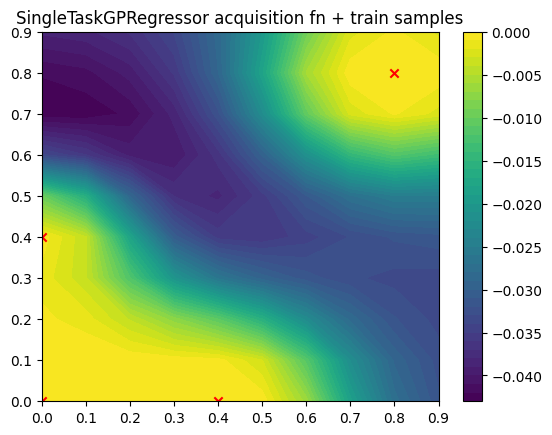

In [ ]:
fig_acq, ax_acq = plotter.plot_function(acq_fn, candidate_set.clone().to("cpu"), xi=xi, yi=yi)
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("SingleTaskGPRegressor acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

# Custom fitting

### Custom fitting: Exact GP

BOTorch Tutorial: https://botorch.org/tutorials/fit_model_with_torch_optimizer

In [ ]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=10,
    train_path="data/branin/data_%i_train.csv" % 10,
    train_fraction=1.0,
    float_precision=64,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper()
candidate_set, xi, yi = dataset_handler.get_candidate_set()
sample_states, _ = dataset_handler.train_data[:]


In [ ]:

from activelearning.utils.helper_functions import dataloader_to_data
from gpytorch.constraints import GreaterThan
from torch.optim import SGD

def custom_fit(surrogate, train_data):
    train_x, train_y = dataloader_to_data(train_data)
    train_y = train_y * surrogate.target_factor
    model = surrogate.model_class(
        train_x,
        train_y.unsqueeze(-1),
        outcome_transform=surrogate.outcome_transform,
        likelihood=surrogate.likelihood,
        **surrogate.kwargs,
    )
    gp_model = (
        model.model if hasattr(model, "model") else model
    )  # model.model needed for SingleTaskVariationalGP because it is a wrapper around the actual stochastic GP
    
    gp_model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

    mll = surrogate.mll_class(
        gp_model.likelihood,
        gp_model,
        **surrogate.mll_args,
    )
    mll = mll.to(train_x)

    optimizer = SGD([{"params": model.parameters()}], lr=0.1)
    NUM_EPOCHS = 150
    model.train()

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output = model(train_x)
        # Compute negative marginal log likelihood
        loss = -mll(output, train_y)
        # back prop gradients
        loss.backward()
        # print every 10 iterations
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
                # f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} "
                f"noise: {model.likelihood.noise.item():>4.3f}"
            )
        optimizer.step()
    return model

In [ ]:
from activelearning.surrogate.gp_surrogate import SingleTaskGPRegressor
surrogate = SingleTaskGPRegressor(64, "cpu")
# surrogate.fit(train_data)
model = custom_fit(surrogate, train_data)

from activelearning.acquisition.acquisition import BOTorchMaxValueEntropyAcquisition
acq_fn = BOTorchMaxValueEntropyAcquisition(model, device="cpu", float_precision=64)

Epoch  10/150 - Loss: 3.247 noise: 2.010
Epoch  20/150 - Loss: 3.126 noise: 1.881
Epoch  30/150 - Loss: 3.058 noise: 1.753
Epoch  40/150 - Loss: 3.013 noise: 1.629
Epoch  50/150 - Loss: 2.980 noise: 1.508
Epoch  60/150 - Loss: 2.951 noise: 1.391
Epoch  70/150 - Loss: 2.925 noise: 1.278
Epoch  80/150 - Loss: 2.901 noise: 1.171
Epoch  90/150 - Loss: 2.878 noise: 1.071
Epoch 100/150 - Loss: 2.857 noise: 0.976
Epoch 110/150 - Loss: 2.836 noise: 0.888
Epoch 120/150 - Loss: 2.816 noise: 0.808
Epoch 130/150 - Loss: 2.796 noise: 0.734
Epoch 140/150 - Loss: 2.778 noise: 0.667
Epoch 150/150 - Loss: 2.761 noise: 0.606


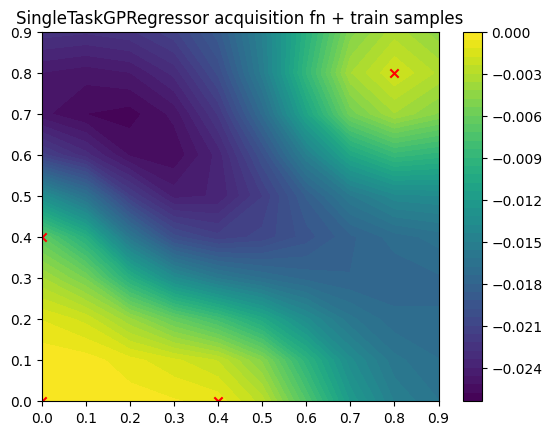

In [ ]:
fig_acq, ax_acq = plotter.plot_function(acq_fn, candidate_set.clone().to("cpu"), xi=xi, yi=yi)
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("SingleTaskGPRegressor acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

### Custom fitting: Stochastic Variational GP

In [1]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=100,
    train_path="data/branin/large_branin_quadrant_100.csv",
    train_fraction=1.0,
    float_precision=32,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper(device="cpu")
candidate_set, xi, yi = dataset_handler.get_candidate_set(as_dataloader=True)
sample_states, train_y = dataset_handler.train_data[:]


In [2]:
from activelearning.surrogate.gp_surrogate import SVGPSurrogate
from botorch.models.transforms.outcome import Standardize
from botorch.models import SingleTaskVariationalGP
import gpytorch
from functools import partial

surrogate = SVGPSurrogate(model_class=SingleTaskVariationalGP,
            mll_class=gpytorch.mlls.VariationalELBO,
            likelihood=None,
            outcome_transform=Standardize(m=1),
            float_precision=32,
            device='cpu',
            maximize=False,
            mll_args={"num_data": len(train_data)},
            train_epochs=160,
            lr=0.1,
            )
surrogate.fit(train_data)

from activelearning.acquisition.acquisition import BOTorchMonteCarloAcquisition
import botorch
acq_fn = BOTorchMonteCarloAcquisition(surrogate.model, botorch.acquisition.monte_carlo.qNoisyExpectedImprovement, dataset_handler, "cpu", 32)


/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/approximate_gp.py:367: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y)


Epoch:   0%|          | 0/160 [00:00<?, ?it/s]

(<Figure size 640x480 with 2 Axes>, <Axes: >)

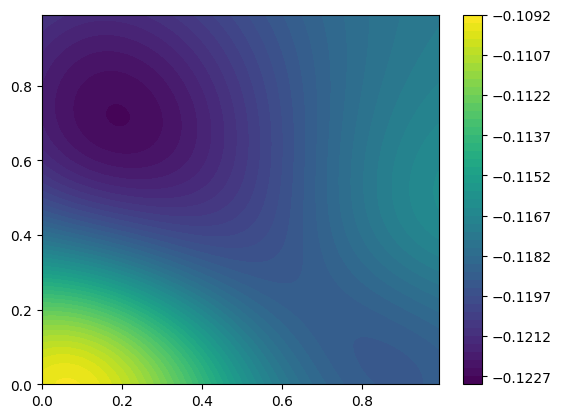

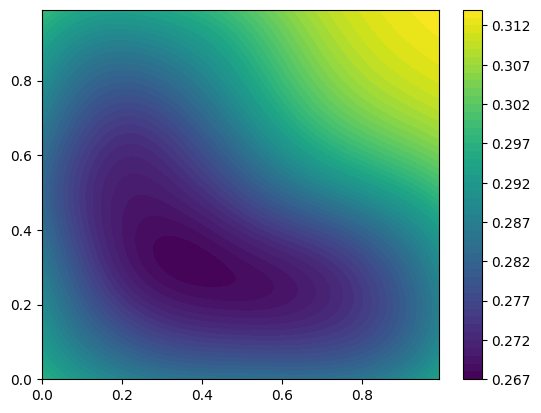

In [3]:
plotter.plot_function(surrogate.get_predictions, candidate_set, xi=xi, yi=yi, output_index=0, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))
plotter.plot_function(surrogate.get_predictions, candidate_set, xi=xi, yi=yi, output_index=1, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))

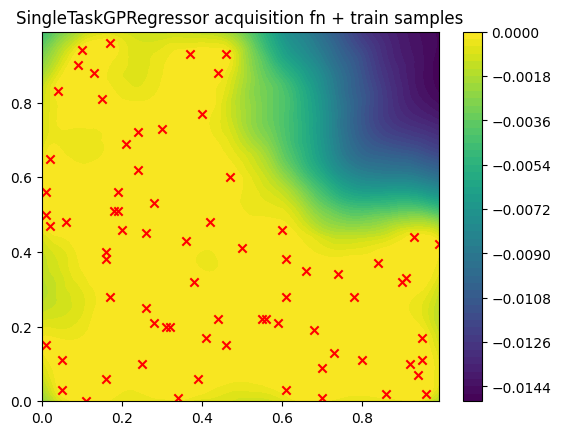

In [4]:
fig_acq, ax_acq = plotter.plot_function(acq_fn, candidate_set, xi=xi, yi=yi, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("SingleTaskGPRegressor acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

# DKL Surrogate

### Test MLP on Branin

In [ ]:
from activelearning.dataset.grid import HartmannDatasetHandler, BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=10,
    train_path="data/branin/data_%i_train.csv" % 10,
    train_fraction=1.0,
    float_precision=64,
)
# dataset_handler = HartmannDatasetHandler(
#     grid_size=10,
#     train_path="./data/hartmann/data_train.csv",
#     train_fraction=1.0,
#     float_precision=64,
# )
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper()
candidate_set, xi, yi = dataset_handler.get_candidate_set()
# plot_set, xi, yi = dataset_handler.get_candidate_set(step=2, as_dataloader=False)
sample_states, _ = dataset_handler.train_data[:]


In [ ]:
import torch
from activelearning.surrogate.feature_encoder.mlp import MLP

model = MLP(n_input=2, n_hid=64, n_layers=2, n_feature_dim=2, n_output=1, float_precision=64)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

# training parameters
n_epochs = 100   # number of epochs to run

# training loop
for epoch in range(n_epochs):
    print(epoch)
    model.train()
    for X_batch, y_batch in train_data:
        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        print(loss)
        # backward pass
        optim.zero_grad()
        loss.backward()
        # update weights
        optim.step()


0
tensor(0.8249, dtype=torch.float64, grad_fn=<MseLossBackward0>)
1


/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.8097, dtype=torch.float64, grad_fn=<MseLossBackward0>)
2
tensor(0.7976, dtype=torch.float64, grad_fn=<MseLossBackward0>)
3
tensor(0.7893, dtype=torch.float64, grad_fn=<MseLossBackward0>)
4
tensor(0.8080, dtype=torch.float64, grad_fn=<MseLossBackward0>)
5
tensor(0.7838, dtype=torch.float64, grad_fn=<MseLossBackward0>)
6
tensor(0.7186, dtype=torch.float64, grad_fn=<MseLossBackward0>)
7
tensor(0.7228, dtype=torch.float64, grad_fn=<MseLossBackward0>)
8
tensor(0.6694, dtype=torch.float64, grad_fn=<MseLossBackward0>)
9
tensor(0.6793, dtype=torch.float64, grad_fn=<MseLossBackward0>)
10
tensor(0.6632, dtype=torch.float64, grad_fn=<MseLossBackward0>)
11
tensor(0.6572, dtype=torch.float64, grad_fn=<MseLossBackward0>)
12
tensor(0.7069, dtype=torch.float64, grad_fn=<MseLossBackward0>)
13
tensor(0.5371, dtype=torch.float64, grad_fn=<MseLossBackward0>)
14
tensor(0.5500, dtype=torch.float64, grad_fn=<MseLossBackward0>)
15
tensor(0.5043, dtype=torch.float64, grad_fn=<MseLossBackward0>)
16
ten

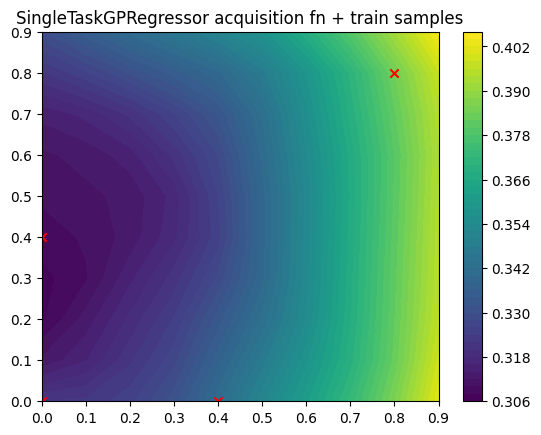

In [ ]:
model.eval()
fig_mlp, ax_mlp = plotter.plot_function(model, candidate_set.clone().to("cpu"), xi=xi, yi=yi)
fig_mlp, ax_mlp = plotter.plot_samples(sample_states, ax_mlp, fig_mlp)
ax_mlp.set_title("mlp + train samples")
# Note: seems to learn correctly

### Test MLP + GP on Branin

In [ ]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=10,
    train_path="data/branin/data_%i_train.csv" % 10,
    train_fraction=1.0,
    float_precision=32,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper()
candidate_set, xi, yi = dataset_handler.get_candidate_set(as_dataloader=True)
# plot_set, xi, yi = dataset_handler.get_candidate_set(step=2, as_dataloader=False)
sample_states, _ = dataset_handler.train_data[:]

# from activelearning.dataset.grid import BraninDatasetHandler
# from activelearning.utils.plotter import PlotHelper


# # Dataset
# dataset_handler = BraninDatasetHandler(
#     grid_size=100,
#     train_path="data/branin/large_branin_quadrant_100.csv",
#     train_fraction=1.0,
#     float_precision=32,
# )
# train_data, test_data = dataset_handler.get_dataloader()

# plotter = PlotHelper(device="cpu")
# candidate_set, xi, yi = dataset_handler.get_candidate_set(as_dataloader=True)
# sample_states, train_y = dataset_handler.train_data[:]


In [ ]:
from activelearning.surrogate.gp_surrogate import GPSurrogate
import gpytorch
from botorch.models.gp_regression_fidelity import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from activelearning.surrogate.feature_encoder.mlp import MLP, Identity
from activelearning.surrogate.gp_models import SingleTaskDKLModel

# feature_extractor = Identity(2)
feature_extractor = MLP(
    n_input=2,
    n_hidden=[1000, 500, 50],
    n_output=7,
    float_precision=32,
)

surrogate = GPSurrogate(
    32,
    "cpu",
    SingleTaskDKLModel,
    gpytorch.mlls.ExactMarginalLogLikelihood,
    gpytorch.likelihoods.GaussianLikelihood(),
    Standardize(m=1),
    feature_extractor=feature_extractor,
)
surrogate.fit(train_data)

from activelearning.acquisition.acquisition import BOTorchMaxValueEntropyAcquisition

acq_fn = BOTorchMaxValueEntropyAcquisition(
    surrogate.model, device="cpu", float_precision=32
)

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Text(0.5, 1.0, 'DKLModel uncertainty')

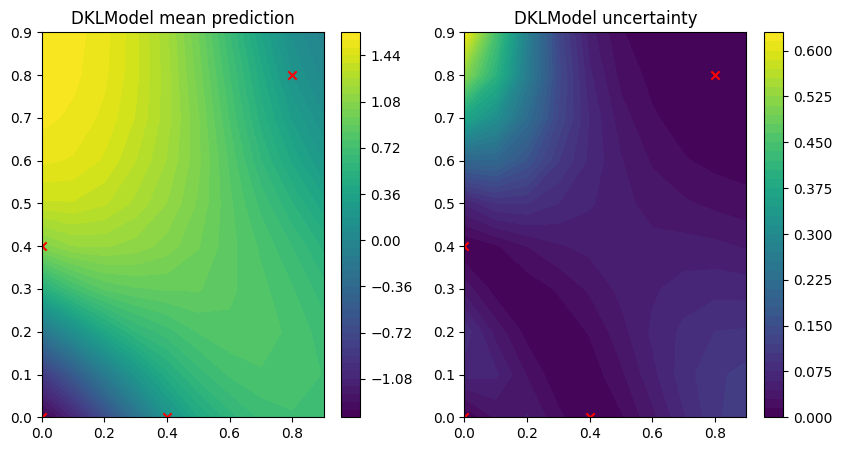

In [ ]:
import torch

def get_pred(x):
    surrogate.model.eval()
    surrogate.likelihood.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(
        False
    ), gpytorch.settings.fast_pred_var():
        preds = surrogate.model(x.to(torch.float32))
    return torch.concat([preds.mean.unsqueeze(0), preds.variance.unsqueeze(0)],dim=0)


plotter = PlotHelper()
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,5))

plotter.plot_function(
    get_pred,
    candidate_set,#.to(torch.float32).clone().to("cpu"),
    output_index=0,
    xi=xi,
    yi=yi,
    fig=fig,
    ax=axs[0],
    size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2))
)
plotter.plot_samples(sample_states, axs[0], fig)
axs[0].set_title("DKLModel mean prediction")

plotter.plot_function(
    get_pred,
    candidate_set,#.to(torch.float32).clone().to("cpu"),
    output_index=1,
    xi=xi,
    yi=yi,
    fig=fig,
    ax=axs[1],
    size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2))
)
plotter.plot_samples(sample_states, axs[1], fig)
axs[1].set_title("DKLModel uncertainty")

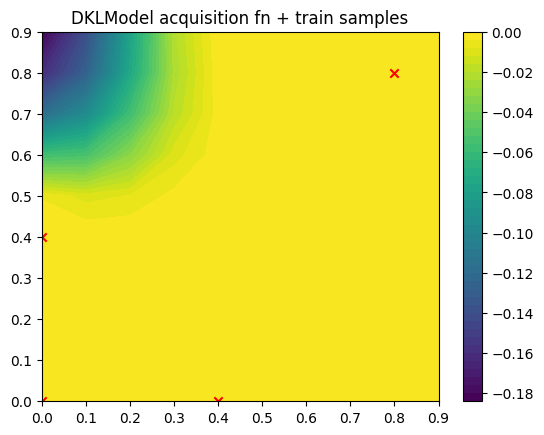

In [ ]:
import torch

plotter = PlotHelper()

fig_acq, ax_acq = plotter.plot_function(
    acq_fn,
    candidate_set,#.to(torch.float32).clone().to("cpu"),
    xi=xi,
    yi=yi,
    size_x=int(len(candidate_set.dataset) ** (1 / 2)),
    size_y=int(len(candidate_set.dataset) ** (1 / 2)),
)
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("DKLModel acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

### Test DKL with hydra instantiation

In [ ]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=10,
    train_path="data/branin/data_%i_train.csv" % 10,
    train_fraction=1.0,
    float_precision=32,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper()
candidate_set, xi, yi = dataset_handler.get_candidate_set()
# plot_set, xi, yi = dataset_handler.get_candidate_set(step=2, as_dataloader=False)
sample_states, _ = dataset_handler.train_data[:]

In [ ]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/surrogate")

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="dkl.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config)


{'_target_': 'activelearning.surrogate.gp_surrogate.GPSurrogate', 'model_class': {'_target_': 'activelearning.surrogate.gp_models.SingleTaskDKLModel', '_partial_': True}, 'mll_class': {'_target_': 'gpytorch.mlls.ExactMarginalLogLikelihood', '_partial_': True}, 'likelihood': {'_target_': 'gpytorch.likelihoods.GaussianLikelihood'}, 'outcome_transform': {'_target_': 'botorch.models.transforms.outcome.Standardize', 'm': 1}, 'feature_extractor': 'mlp'}


In [ ]:
surrogate = hydra.utils.instantiate(
    config,
    float_precision=32,
    device="cpu"
)
surrogate.fit(train_data)

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


In [ ]:
abs_config_dir = os.path.abspath("config/acquisition")

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="botorch.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config)

acq_fn = hydra.utils.instantiate(
    config,
    surrogate_model=surrogate.model,
    device="cpu",
    float_precision=32,
)

{'_target_': 'activelearning.acquisition.acquisition.BOTorchAcqHandler', 'acq_fn_class': 'qLowerBoundMaxValueEntropy'}


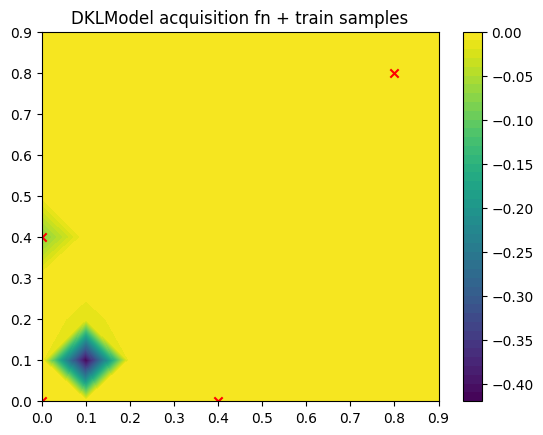

In [ ]:
import torch
plotter = PlotHelper()
fig_acq, ax_acq = plotter.plot_function(acq_fn, candidate_set.to(torch.float32).clone().to("cpu"), xi=xi, yi=yi)
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("DKLModel acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

### Test DKL with Kernel Wrapper

Seems to work well; 
TODO: the network weights are only modified very slightly... try to use a custom training loop to see if we get better results

slight disadvantage with this approach: feature extractor is called twice (once for the kernel and once for the mean module)

In [ ]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=10,
    train_path="data/branin/data_10_train.csv",
    train_fraction=1.0,
    float_precision=32,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper(device="cpu")
candidate_set, xi, yi = dataset_handler.get_candidate_set(as_dataloader=True)
sample_states, train_y = dataset_handler.train_data[:]


In [ ]:
from botorch.models.utils.gpytorch_modules import (
    get_matern_kernel_with_gamma_prior,
)
from gpytorch.means import ConstantMean
from activelearning.surrogate.feature_encoder.mlp import MLP, Identity
import torch
from activelearning.surrogate.gp_kernels import DeepKernelWrapper, DeepKernelConstantMean

# feature_extractor = Identity(2)
feature_extractor = MLP(
    n_input=2, n_hidden=[1000, 500, 50], n_output=7, float_precision=32
)

covar_module = DeepKernelWrapper(
    get_matern_kernel_with_gamma_prior(
        ard_num_dims=feature_extractor.n_output,
        batch_shape=torch.Size(),
    ),
    feature_extractor,
)  # .to(train_X)
# mean_module = ConstantMean(batch_shape=torch.Size())
mean_module = DeepKernelConstantMean(feature_extractor)

In [ ]:
from activelearning.surrogate.gp_surrogate import GPSurrogate
from botorch.models.transforms.outcome import Standardize
from botorch.models import SingleTaskGP
import gpytorch
from functools import partial


surrogate = GPSurrogate(model_class=partial(SingleTaskGP, covar_module=covar_module, mean_module=mean_module),
            mll_class=gpytorch.mlls.ExactMarginalLogLikelihood,
            likelihood=None,
            outcome_transform=Standardize(m=1),
            float_precision=32,
            device='cpu',
            maximize=False,
            )
surrogate.fit(train_data)

from activelearning.acquisition.acquisition import BOTorchMonteCarloAcquisition
import botorch
acq_fn = BOTorchMonteCarloAcquisition(surrogate.model, botorch.acquisition.monte_carlo.qExpectedImprovement, dataset_handler, "cpu", 32)

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


DeepKernelConstantMean(
  (feature_extractor): MLP(
    (linear1): Linear(in_features=2, out_features=1000, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=1000, out_features=500, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=500, out_features=50, bias=True)
    (relu3): ReLU()
    (linear_out): Linear(in_features=50, out_features=7, bias=True)
    (layer_norm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
  )
) DeepKernelWrapper(
  (base_kernel): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
  (feature_extractor): MLP(
    (linear1): Linear(in_features=2, out_features=1000, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=1000, out_features=500, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=500, out_features=50, bias=True)
    (rel

DeepKernelConstantMean(
  (feature_extractor): MLP(
    (linear1): Linear(in_features=2, out_features=1000, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=1000, out_features=500, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=500, out_features=50, bias=True)
    (relu3): ReLU()
    (linear_out): Linear(in_features=50, out_features=7, bias=True)
    (layer_norm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
  )
) DeepKernelWrapper(
  (base_kernel): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
  (feature_extractor): MLP(
    (linear1): Linear(in_features=2, out_features=1000, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=1000, out_features=500, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=500, out_features=50, bias=True)
    (rel

(<Figure size 640x480 with 2 Axes>, <Axes: >)

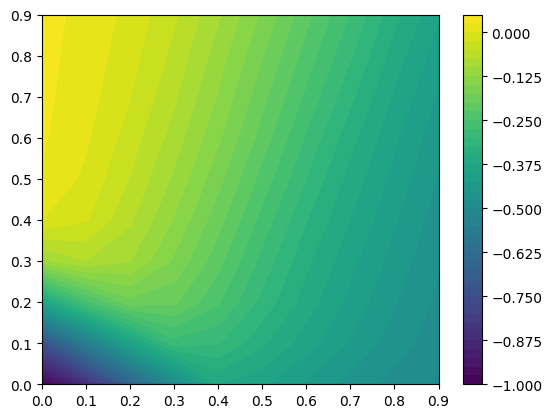

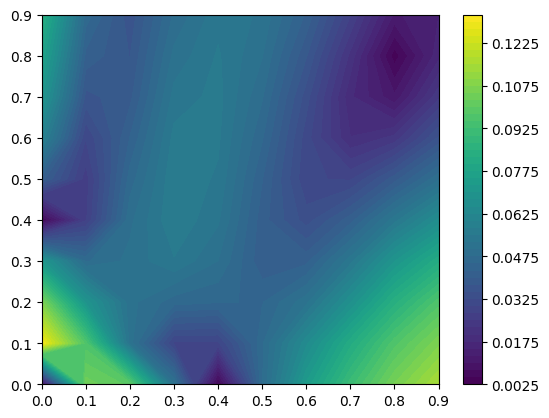

In [ ]:
plotter.plot_function(surrogate.get_predictions, candidate_set, xi=xi, yi=yi, output_index=0, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))
plotter.plot_function(surrogate.get_predictions, candidate_set, xi=xi, yi=yi, output_index=1, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))

DeepKernelConstantMean(
  (feature_extractor): MLP(
    (linear1): Linear(in_features=2, out_features=1000, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=1000, out_features=500, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=500, out_features=50, bias=True)
    (relu3): ReLU()
    (linear_out): Linear(in_features=50, out_features=7, bias=True)
    (layer_norm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
  )
) DeepKernelWrapper(
  (base_kernel): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
  (feature_extractor): MLP(
    (linear1): Linear(in_features=2, out_features=1000, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=1000, out_features=500, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=500, out_features=50, bias=True)
    (rel

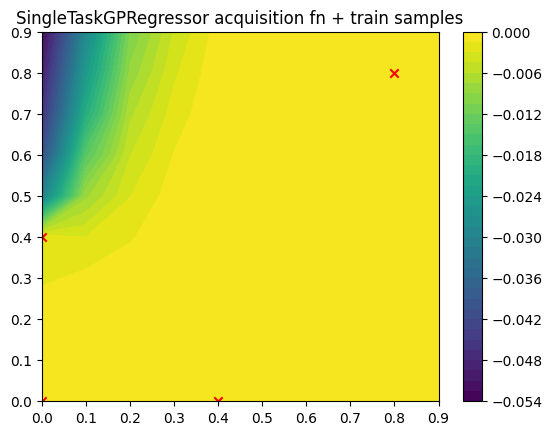

In [ ]:
fig_acq, ax_acq = plotter.plot_function(acq_fn, candidate_set, xi=xi, yi=yi, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("SingleTaskGPRegressor acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

### Test Stochastic Variational GP with Branin

In [ ]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=100,
    train_path="data/branin/large_branin_quadrant_100.csv",
    train_fraction=1.0,
    float_precision=32,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper(device="cpu")
candidate_set, xi, yi = dataset_handler.get_candidate_set(as_dataloader=True)
sample_states, train_y = dataset_handler.train_data[:]


In [ ]:
from activelearning.surrogate.gp_surrogate import GPSurrogate
from botorch.models.transforms.outcome import Standardize
from botorch.models import SingleTaskVariationalGP
import gpytorch
from functools import partial

surrogate = GPSurrogate(model_class=SingleTaskVariationalGP,
            mll_class=gpytorch.mlls.VariationalELBO,
            likelihood=None,
            outcome_transform=Standardize(m=1),
            float_precision=32,
            device='cpu',
            maximize=False,
            mll_args={"num_data": len(train_data)}
            )
surrogate.fit(train_data)

from activelearning.acquisition.acquisition import BOTorchMonteCarloAcquisition
import botorch
acq_fn = BOTorchMonteCarloAcquisition(surrogate.model, botorch.acquisition.monte_carlo.qNoisyExpectedImprovement, dataset_handler, "cpu", 32)
# acq_fn = BOTorchMonteCarloAcquisition(surrogate.model, botorch.acquisition.monte_carlo.qExpectedImprovement, dataset_handler, "cpu", 32)

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/approximate_gp.py:367: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y)


(<Figure size 640x480 with 2 Axes>, <Axes: >)

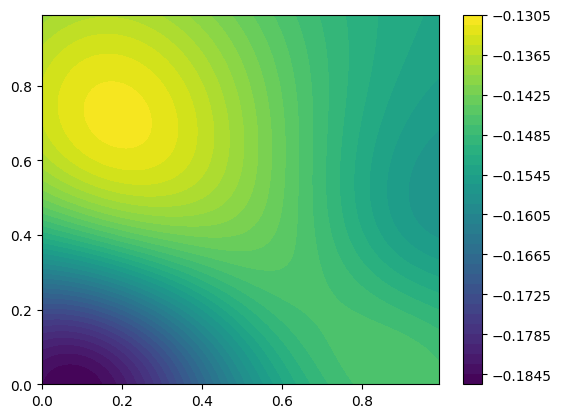

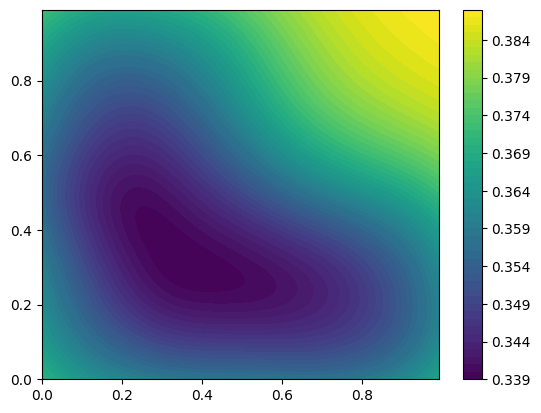

In [ ]:
plotter.plot_function(surrogate.get_predictions, candidate_set, xi=xi, yi=yi, output_index=0, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))
plotter.plot_function(surrogate.get_predictions, candidate_set, xi=xi, yi=yi, output_index=1, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))

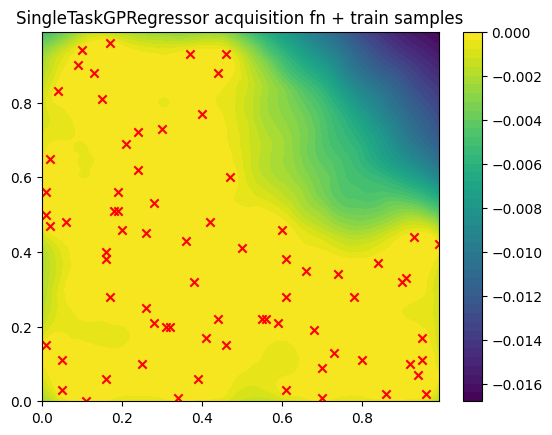

In [ ]:
fig_acq, ax_acq = plotter.plot_function(acq_fn, candidate_set, xi=xi, yi=yi, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("SingleTaskGPRegressor acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

### Test SV DKL with Kernel Wrapper on Branin

In [ ]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=100,
    train_path="data/branin/large_branin_quadrant_100.csv",
    train_fraction=1.0,
    float_precision=32,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper(device="cpu")
candidate_set, xi, yi = dataset_handler.get_candidate_set(as_dataloader=True)
sample_states, train_y = dataset_handler.train_data[:]


In [ ]:
from botorch.models.utils.gpytorch_modules import (
    get_matern_kernel_with_gamma_prior,
)
from gpytorch.means import ConstantMean
from activelearning.surrogate.feature_encoder.mlp import MLP, Identity
import torch
from activelearning.surrogate.gp_kernels import DeepKernelConstantMean, DeepKernelWrapper

# feature_extractor = Identity(2)
feature_extractor = MLP(n_input=2, n_hidden=[16, 16], n_output=5, float_precision=32)


covar_module = DeepKernelWrapper(
    get_matern_kernel_with_gamma_prior(
        ard_num_dims=feature_extractor.n_output,
        batch_shape=torch.Size(),
    ),
    feature_extractor,
)#.to(train_X)
mean_module = DeepKernelConstantMean(feature_extractor, batch_shape=torch.Size())#.to(train_X)

In [ ]:
from activelearning.surrogate.gp_surrogate import GPSurrogate
from botorch.models.transforms.outcome import Standardize
from botorch.models import SingleTaskVariationalGP
import gpytorch
from functools import partial


surrogate = GPSurrogate(model_class=partial(SingleTaskVariationalGP, covar_module=covar_module, mean_module=mean_module),
            mll_class=gpytorch.mlls.VariationalELBO,
            likelihood=None,
            outcome_transform=Standardize(m=1),
            float_precision=32,
            device='cpu',
            maximize=False,
            mll_args={"num_data": len(train_data)}
            )
surrogate.fit(train_data)

from activelearning.acquisition.acquisition import BOTorchMonteCarloAcquisition
import botorch
acq_fn = BOTorchMonteCarloAcquisition(surrogate.model, botorch.acquisition.monte_carlo.qNoisyExpectedImprovement, dataset_handler, "cpu", 32)
# acq_fn = BOTorchMonteCarloAcquisition(surrogate.model, botorch.acquisition.monte_carlo.qExpectedImprovement, dataset_handler, "cpu", 32)

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/approximate_gp.py:367: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y)


torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])


torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([18, 

(<Figure size 640x480 with 2 Axes>, <Axes: >)

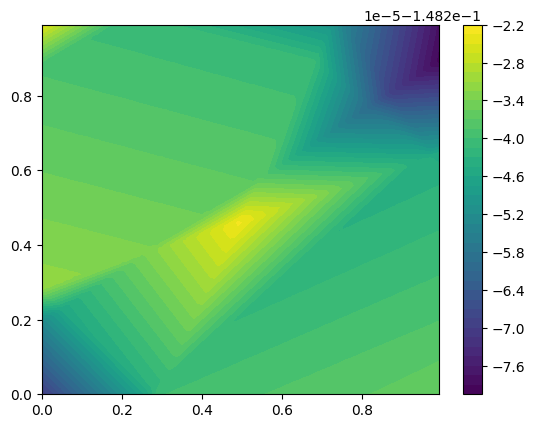

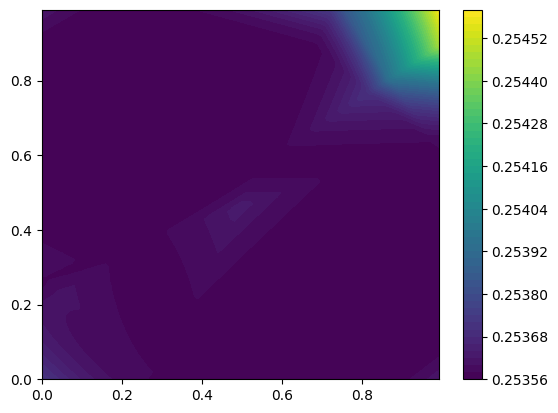

In [ ]:
plotter.plot_function(surrogate.get_predictions, candidate_set, xi=xi, yi=yi, output_index=0, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))
plotter.plot_function(surrogate.get_predictions, candidate_set, xi=xi, yi=yi, output_index=1, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))

torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])


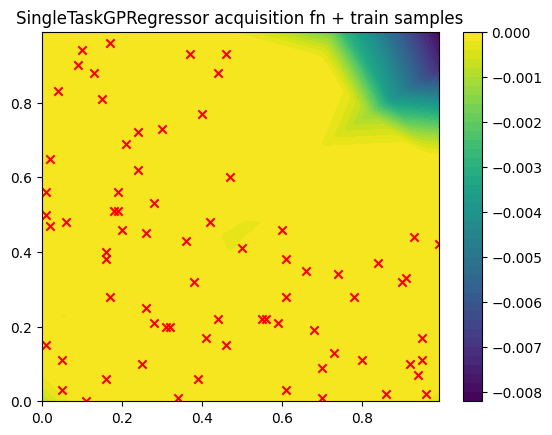

In [ ]:
fig_acq, ax_acq = plotter.plot_function(acq_fn, candidate_set, xi=xi, yi=yi, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("SingleTaskGPRegressor acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

### deprecated -- Test SV DKL with GP model wrapper

In [ ]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=100,
    train_path="data/branin/large_branin_quadrant_100.csv",
    train_fraction=1.0,
    float_precision=32,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper(device="cpu")
candidate_set, xi, yi = dataset_handler.get_candidate_set(as_dataloader=True)
sample_states, train_y = dataset_handler.train_data[:]

In [ ]:
from gpytorch.kernels import Kernel
class DeepKernelWrapper(Kernel):
    @property
    def is_stationary(self) -> bool:
        """
        Kernel is stationary if base kernel is stationary.
        """
        return self.base_kernel.is_stationary

    def __init__(
        self,
        base_kernel: Kernel,
        feature_extractor,
        **kwargs,
    ):
        if base_kernel.active_dims is not None:
            kwargs["active_dims"] = base_kernel.active_dims
        super(DeepKernelWrapper, self).__init__(**kwargs)
        
        self.base_kernel = base_kernel
        self.feature_extractor = feature_extractor

    def forward(self, x1, x2, last_dim_is_batch=False, diag=False, **params):
        x1 = self.feature_extractor(x1)
        x2 = self.feature_extractor(x2)
        base_kernel_output = self.base_kernel.forward(x1, x2, diag=diag, last_dim_is_batch=last_dim_is_batch, **params)
        return base_kernel_output

    def num_outputs_per_input(self, x1, x2):
        return self.base_kernel.num_outputs_per_input(x1, x2)

    def prediction_strategy(self, train_inputs, train_prior_dist, train_labels, likelihood):
        return self.base_kernel.prediction_strategy(train_inputs, train_prior_dist, train_labels, likelihood)


In [ ]:
# from botorch.models import _SingleTaskVariationalGP, GPyTorchModel
from botorch.models.approximate_gp import (
    _SingleTaskVariationalGP,
    ApproximateGPyTorchModel,
)
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.utils import validate_input_scaling
from botorch.models.utils.gpytorch_modules import (
    get_gaussian_likelihood_with_gamma_prior,
    get_matern_kernel_with_gamma_prior,
)
from botorch.models.utils.inducing_point_allocators import (
    GreedyVarianceReduction,
    InducingPointAllocator,
)
import copy
import torch
from torch.nn import Module
from botorch.posteriors.gpytorch import GPyTorchPosterior
from gpytorch.means import ConstantMean, Mean


class SingleTaskSVDKLModel(_SingleTaskVariationalGP, GPyTorchModel):
    # This model is a wrapper that connects a feature extractor
    # (i.e. any kind of pytorch model) with the SingleTaskVariationalGP botorch model
    # adapted from "SingleTaskVariationalGP" wrapper class

    # DKL code adapted from:
    # https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/KISSGP_Deep_Kernel_Regression_CUDA.html
    # https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.html
    def __init__(
        self,
        train_X,
        train_Y,
        feature_extractor,
        likelihood,
        outcome_transform,
    ):
        if train_Y is not None:
            if outcome_transform is not None:
                train_Y, _ = outcome_transform(train_Y)
            self._validate_tensor_args(X=train_X, Y=train_Y)
            validate_input_scaling(train_X=train_X, train_Y=train_Y)

        self._input_batch_shape = train_X.shape[:-2]
        aug_batch_shape = copy.deepcopy(self._input_batch_shape)
        self._aug_batch_shape = aug_batch_shape

        covar_module = DeepKernelWrapper(
            get_matern_kernel_with_gamma_prior(
                ard_num_dims=feature_extractor.n_output,#train_X.shape[-1],
                batch_shape=self._aug_batch_shape,
            ),
            feature_extractor,
        ).to(train_X)
        mean_module = ConstantMean(batch_shape=self._aug_batch_shape).to(train_X)

        # inducing_point_allocator = GreedyVarianceReduction()
        # inducing_points = inducing_point_allocator.allocate_inducing_points(
        #     inputs=feature_extractor(train_X),
        #     covar_module=covar_module,
        #     num_inducing=len(train_X),
        #     input_batch_shape=len(train_X),
        # )

        GPyTorchModel.__init__(self)
        _SingleTaskVariationalGP.__init__(
            self,
            train_X=train_X,
            covar_module=covar_module,
            mean_module=mean_module,
            # inducing_points=inducing_points
        )

        if likelihood is None:
            likelihood = get_gaussian_likelihood_with_gamma_prior(
                batch_shape=self._aug_batch_shape
            )
        else:
            self._is_custom_likelihood = True

        self.likelihood = likelihood
        self._inducing_point_allocator = GreedyVarianceReduction()

        if outcome_transform is not None:
            self.outcome_transform = outcome_transform

        # for model fitting utilities
        # TODO: make this a flag?
        self.train_inputs = [train_X]
        if train_Y is not None:
            self.train_targets = train_Y.squeeze(-1)

        self.to(train_X)

        # dkl stuff
        self.feature_extractor = feature_extractor
        # This module will scale the NN features so that they're nice values
        # self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # projected_x = self.feature_extractor(x)
        projected_x = x
        # projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"
        return super().forward(projected_x)

    # the following properties and methods are copied from ApproximateGPyTorchModel
    @property
    def num_outputs(self):
        return 1

    # def eval(self):
    #     r"""Puts the model in `eval` mode."""
    #     return Module.eval(self)

    # def train(self, mode: bool = True):
    #     r"""Put the model in `train` mode.

    #     Args:
    #         mode: A boolean denoting whether to put in `train` or `eval` mode.
    #             If `False`, model is put in `eval` mode.
    #     """
    #     return Module.train(self, mode=mode)
    def __call__(self, inputs, prior=False, **kwargs):
        # projected_x = self.feature_extractor(inputs)
        projected_x = inputs
        return self.variational_strategy(projected_x, prior=prior, **kwargs)

    def posterior(
        self, X, output_indices=None, observation_noise=False, *args, **kwargs
    ):
        self.eval()  # make sure model is in eval mode

        # projected_x = self.feature_extractor(X)
        projected_x = X
        dist = self.__call__(projected_x)
        if observation_noise:
            dist = self.likelihood(dist, *args, **kwargs)

        posterior = GPyTorchPosterior(distribution=dist)
        if hasattr(self, "outcome_transform"):
            posterior = self.outcome_transform.untransform_posterior(posterior)
        return posterior

In [ ]:
from activelearning.surrogate.gp_surrogate import GPSurrogate
import gpytorch
from botorch.models.transforms.outcome import Standardize
from activelearning.surrogate.feature_encoder.mlp import MLP, Identity

# feature_extractor = Identity(2)
feature_extractor = MLP(n_input=2, n_hidden=[16, 16], n_output=5, float_precision=32)

surrogate = GPSurrogate(model_class=SingleTaskSVDKLModel,
            mll_class=gpytorch.mlls.VariationalELBO,
            likelihood=None,
            outcome_transform=Standardize(m=1),
            float_precision=32,
            device='cpu',
            maximize=False,
            feature_extractor=feature_extractor,
            mll_args={"num_data": len(train_data)}
            )
surrogate.fit(train_data)

from activelearning.acquisition.acquisition import BOTorchMonteCarloAcquisition
import botorch
acq_fn = BOTorchMonteCarloAcquisition(surrogate.model, botorch.acquisition.monte_carlo.qNoisyExpectedImprovement, dataset_handler, "cpu", 32)

/tmp/ipykernel_4008038/732647607.py:42: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=train_X, Y=train_Y)


torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])
torch.Size([18, 2]) torch.Size([74, 2])


torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([1, 5]) torch.Size([18, 5]) torch.Size([1, 5])
torch.Size([1, 5]) torch.Size([256, 5]) torch.Size([1, 5])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([1, 5]) torch.Size([18, 5]) torch.Size([1, 5])
torch.Size([1, 5]) torch.Size([256, 5]) torch.Size([1, 5])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([1, 5]) torch.Size([18, 5]) torch.Size([1, 5])
torch.Size([1, 5]) torch.Size([256, 5]) torch.Size([1, 5])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([1, 5]) torch.Size([18, 5]) torch.Size([1, 5])
torch.Size([1, 5]) torch.Size([256, 5]) torch.Size([1, 5])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([1, 5]) torch.Size([18, 5]) torch.Size([1, 5])
torch.Size([1, 5]) torch.Size([256, 5]) torch.Size([1, 5])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size([1, 5]) torch.Size([18, 5]) torch.Size([1, 5])
torch.Size([1, 5]) torch.Size([256, 5]) torch.Size([1, 5])
torch.Size([18, 2]) torch.Size([256, 2])
torch.Size(

(<Figure size 640x480 with 2 Axes>, <Axes: >)

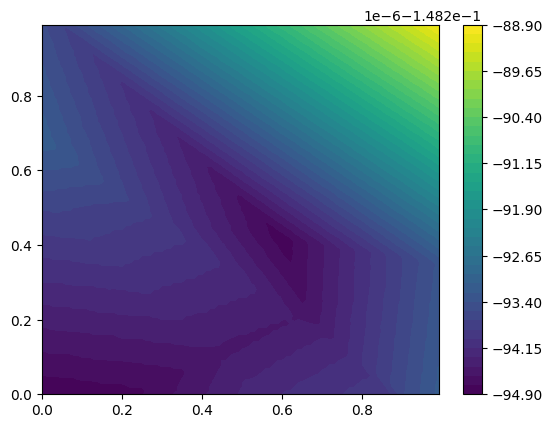

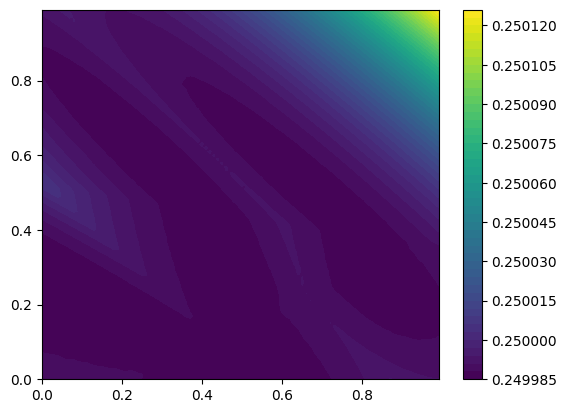

In [ ]:
plotter.plot_function(surrogate.get_predictions, candidate_set, xi=xi, yi=yi, output_index=0, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))
plotter.plot_function(surrogate.get_predictions, candidate_set, xi=xi, yi=yi, output_index=1, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))

torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([1, 1, 5]) torch.Size([256, 18, 5]) torch.Size([1, 5])
torch.Size([1, 1, 5]) torch.Size([256, 18, 5]) torch.Size([1, 5])
torch.Size([1, 1, 5]) torch.Size([256, 75, 5]) torch.Size([1, 5])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([1, 1, 5]) torch.Size([256, 18, 5]) torch.Size([1, 5])
torch.Size([1, 1, 5]) torch.Size([256, 75, 5]) torch.Size([1, 5])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([1, 1, 5]) torch.Size([256, 18, 5]) torch.Size([1, 5])
torch.Size([1, 1, 5]) torch.Size([256, 75, 5]) torch.Size([1, 5])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([1, 1, 5]) torch.Size([256, 18, 5]) torch.Size([1, 5])
torch.Size([1, 1, 5]) torch.Size([256, 75, 5]) torch.Size([1, 5])
torch.Size([256, 18, 2]) torch.Size([256, 75, 2])
torch.Size([1, 1, 5]) torch.Size([256, 18, 5]) torch.Size([1, 5])
torch.Size([1, 1, 5]) torch.Size([256, 75, 5]) torch.Size([1, 5])
torch.Size([256, 18, 2])

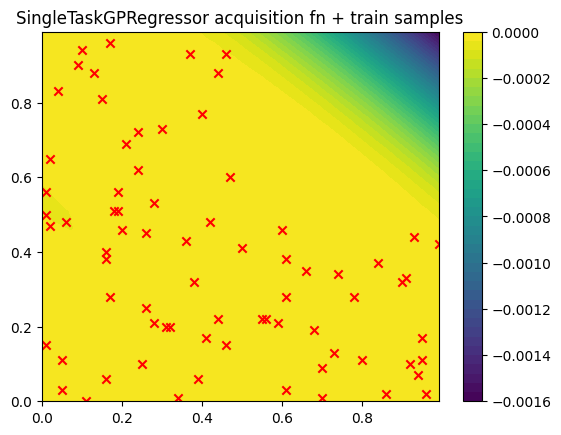

In [ ]:
fig_acq, ax_acq = plotter.plot_function(acq_fn, candidate_set, xi=xi, yi=yi, size_x=int(len(candidate_set.dataset) ** (1 / 2)), size_y=int(len(candidate_set.dataset) ** (1 / 2)))
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("SingleTaskGPRegressor acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import gpytorch

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()


In [ ]:
import tqdm
import torch
num_epochs = 150

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))


epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    for x_batch, y_batch in train_data:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch*-1)
        epochs_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
model.eval()
likelihood.eval()
means = torch.tensor([])
vars = torch.tensor([])
with torch.no_grad():
    for x_batch, y_batch in train_data:
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])
        vars = torch.cat([vars, preds.variance.cpu()])
means, vars

(tensor([-0.4242, -0.3805, -0.4691, -0.4587]),
 tensor([0.0651, 0.0885, 0.0673, 0.0668]))

Text(0.5, 1.0, 'DKLModel uncertainty')

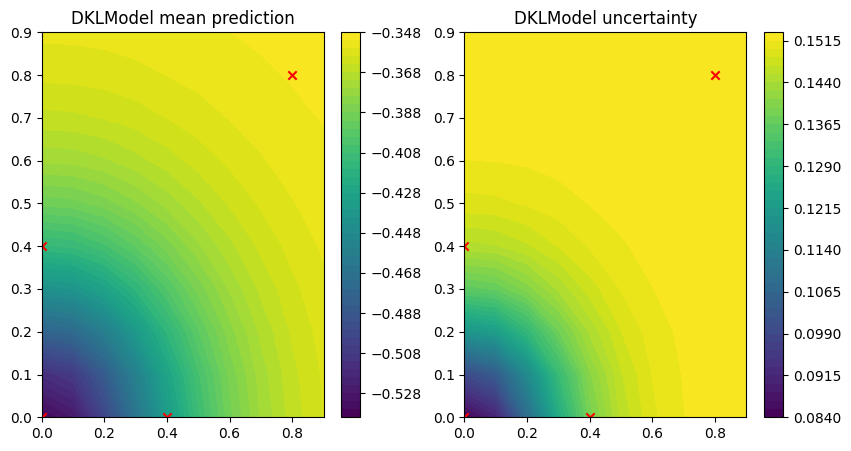

In [ ]:
import torch
import gpytorch

def get_pred(x):
    model.eval()
    model.likelihood.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(
        False
    ), gpytorch.settings.fast_pred_var():
        preds = model(x)

    return preds.mean, preds.variance


plotter = PlotHelper()
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,5))

plotter.plot_function(
    get_pred,
    candidate_set.to(torch.float32).clone().to("cpu"),
    output_index=0,
    xi=xi,
    yi=yi,
    fig=fig,
    ax=axs[0],
)
plotter.plot_samples(sample_states, axs[0], fig)
axs[0].set_title("DKLModel mean prediction")

plotter.plot_function(
    get_pred,
    candidate_set.to(torch.float32).clone().to("cpu"),
    output_index=1,
    xi=xi,
    yi=yi,
    fig=fig,
    ax=axs[1],
)
plotter.plot_samples(sample_states, axs[1], fig)
axs[1].set_title("DKLModel uncertainty")

In [ ]:
train_x, train_y*-1

(tensor([[0.0000, 0.0000],
         [0.0000, 0.4000],
         [0.4000, 0.0000],
         [0.8000, 0.8000]]),
 tensor([-1.0000, -0.3749, -0.0000, -0.3611]))

### deprecated -- Test Stochastic Variational DKL

In [ ]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=10,
    train_path="data/branin/data_%i_train.csv" % 10,
    train_fraction=1.0,
    float_precision=32,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper()
candidate_set, xi, yi = dataset_handler.get_candidate_set()
# plot_set, xi, yi = dataset_handler.get_candidate_set(step=2, as_dataloader=False)
sample_states, _ = dataset_handler.train_data[:]

In [ ]:
from botorch.models.gp_regression_fidelity import SingleTaskGP
from activelearning.surrogate.gp_surrogate import GPSurrogate
import gpytorch
from botorch.models.transforms.outcome import Standardize
from activelearning.surrogate.feature_encoder.mlp import MLP, Identity


class SingleTaskSVDKLModel(gpytorch.models.ApproximateGP):
    # This model is a wrapper that connects a feature extractor
    # (i.e. any kind of pytorch model) with the SingleTaskGP botorch model

    # SVDKL code adapted from:
    # https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.html
    # https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html
    def __init__(
        self, train_x, train_y, feature_extractor, likelihood, outcome_transform
    ):
        super(SingleTaskSVDKLModel, self).__init__(
            train_x,
            train_y,
            likelihood=likelihood,
            outcome_transform=outcome_transform,
        )
        self.feature_extractor = feature_extractor

        # This module will scale the NN features so that they're nice values
        # self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        projected_x = self.feature_extractor(x)
        # projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"
        return super().forward(projected_x)

In [ ]:


feature_extractor = Identity()
# feature_extractor = MLP(n_input=2, n_hidden=[1000, 500, 50], n_output=2, float_precision=32)

surrogate = GPSurrogate(
    32,
    "cpu",
    SingleTaskSVDKLModel,
    gpytorch.mlls.ExactMarginalLogLikelihood,
    gpytorch.likelihoods.GaussianLikelihood(),
    Standardize(m=1),
    feature_extractor=feature_extractor,
)
surrogate.fit(train_data)

from activelearning.acquisition.acquisition import BOTorchAcqHandler
acq_fn = BOTorchAcqHandler(surrogate.model, "qLowerBoundMaxValueEntropy", float_precision=32)


Text(0.5, 1.0, 'DKLModel uncertainty')

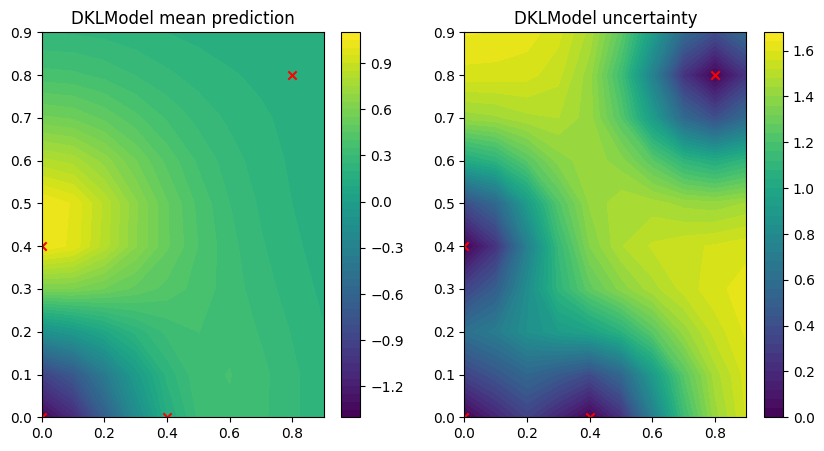

In [ ]:
import torch

def get_pred(x):
    surrogate.model.eval()
    surrogate.likelihood.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(
        False
    ), gpytorch.settings.fast_pred_var():
        preds = surrogate.model(x)

    return preds.mean, preds.variance


plotter = PlotHelper()
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,5))

plotter.plot_function(
    get_pred,
    candidate_set.to(torch.float32).clone().to("cpu"),
    output_index=0,
    xi=xi,
    yi=yi,
    fig=fig,
    ax=axs[0],
)
plotter.plot_samples(sample_states, axs[0], fig)
axs[0].set_title("DKLModel mean prediction")

plotter.plot_function(
    get_pred,
    candidate_set.to(torch.float32).clone().to("cpu"),
    output_index=1,
    xi=xi,
    yi=yi,
    fig=fig,
    ax=axs[1],
)
plotter.plot_samples(sample_states, axs[1], fig)
axs[1].set_title("DKLModel uncertainty")

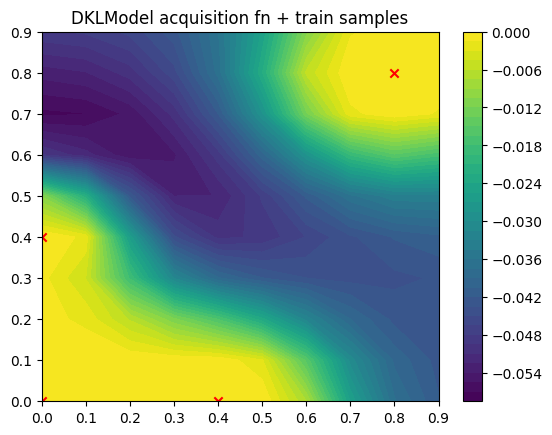

In [ ]:
import torch
plotter = PlotHelper()
fig_acq, ax_acq = plotter.plot_function(acq_fn, candidate_set.to(torch.float32).clone().to("cpu"), xi=xi, yi=yi)
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("DKLModel acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

# GPAX

In [ ]:
# ! pip install gpax

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached rich-13.7.1-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached zipp-3.18.1-py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.8/686.8 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 MB 48.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.4 MB/s eta 0:00:00
Using cached tabulate-0.9.0

In [ ]:
from dataset.grid import BraninDatasetHandler
from utils.plotter import PlotHelper


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=10,
    train_path="../data/branin/data_%i_train.csv" % 10,
    train_fraction=1.0,
    float_precision=64,
)
train_data, test_data = dataset_handler.get_dataloader()

plotter = PlotHelper()
candidate_set, xi, yi = dataset_handler.get_candidate_set()
sample_states, _ = dataset_handler.train_data[:]

In [ ]:
X, y = dataset_handler.train_data[:]

In [ ]:
import gpax

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
# Initialize model
gp_model = gpax.ExactGP(1, kernel='Periodic')
# Run Hamiltonian Monte Carlo to obtain posterior samples for the GP model parameters
gp_model.fit(rng_key, X.numpy(), y.numpy())  # X and y are numpy arrays with dimensions (n, d) and (n,)

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1583.35it/s, 7 steps of size 3.71e-01. acc. prob=0.80]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      2.01      2.75      1.24      0.07      4.30   1046.57      1.00
    k_scale      0.84      0.95      0.58      0.08      1.67    791.61      1.00
      noise      0.66      0.62      0.48      0.05      1.28    798.42      1.00
     period      1.75      2.50      0.96      0.06      4.10   1240.48      1.00



In [ ]:
posterior_mean, f_samples = gp_model.predict(rng_key_predict, candidate_set.numpy())
posterior_mean

Array([0.46143913, 0.33342293, 0.28747463, 0.27863792, 0.298575  ,
       0.2599873 , 0.25136974, 0.25285974, 0.25192553, 0.24820286,
       0.30771962, 0.281817  , 0.24348705, 0.22530074, 0.2222837 ,
       0.21107505, 0.20106764, 0.19925149, 0.20714131, 0.19903511,
       0.2435326 , 0.22250648, 0.21405223, 0.19533485, 0.19016783,
       0.1814943 , 0.17669438, 0.17518537, 0.18452701, 0.17413096,
       0.20644745, 0.1828808 , 0.17435426, 0.18391736, 0.17060304,
       0.16080238, 0.16288184, 0.16527495, 0.16932067, 0.16101295,
       0.1667713 , 0.15009327, 0.14622584, 0.14489967, 0.15566249,
       0.14381717, 0.14352341, 0.14496091, 0.15619974, 0.14433004,
       0.18087584, 0.15447164, 0.1484709 , 0.14833161, 0.15758772,
       0.17007539, 0.15900967, 0.1597045 , 0.16843869, 0.1630068 ,
       0.19229378, 0.16295594, 0.15087843, 0.15734977, 0.16368198,
       0.16552037, 0.18563946, 0.18186684, 0.1817629 , 0.17460325,
       0.20212418, 0.1697534 , 0.15796076, 0.15957087, 0.16926

In [ ]:
def get_predictions(x):
    import torch
    # Compute the upper confidence bound (UCB) acquisition function to derive the next measurement point
    acq = gpax.acquisition.UCB(rng_key_predict, gp_model, x.numpy(), beta=4, maximize=False, noiseless=False)  # B
    return torch.Tensor(acq.tolist())
    # posterior_mean, f_samples = gp_model.predict(rng_key_predict, x.numpy())
    # return torch.Tensor(posterior_mean.tolist())

(<Figure size 640x480 with 2 Axes>, <Axes: >)

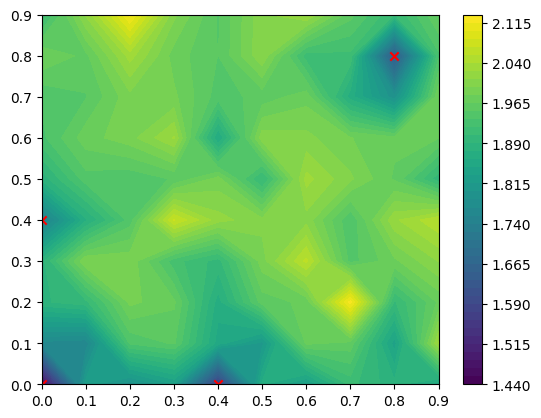

In [ ]:
from utils.plotter import PlotHelper
plot = PlotHelper()
fig, ax = plot.plot_function(get_predictions, candidate_set, xi, yi, output_index=None)
plot.plot_samples(X.numpy(), fig=fig, ax=ax)
# fig, ax = plot.plot_function(gp_model.predict, candidates, xi, yi, output_index="pred_uct")
# plot.plot_samples(x, fig=fig, ax=ax)


# Lightning UQ Box

In [ ]:
# ! pip install lightning-uq-box

In [ ]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.optim import Adam

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import NLL, MCDropoutRegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]
seed_everything(0)  # seed everything for reproducibility
my_temp_dir = tempfile.mkdtemp()
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

Seed set to 0


In [ ]:
network = MLP(
    n_inputs=1,
    n_hidden=[50, 50, 50],
    n_outputs=2,
    dropout_p=0.1,
    activation_fn=nn.Tanh(),
)
mc_dropout_module = MCDropoutRegression(
    model=network,
    optimizer=partial(Adam, lr=1e-2),
    loss_fn=NLL(),
    num_mc_samples=25,
    burnin_epochs=50,
)

In [ ]:
import torch
# Find optimal model hyperparameters
network.train()
mc_dropout_module.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(
    mc_dropout_module.parameters(), lr=1e-2
)  # Includes GaussianLikelihood parameters

from tqdm.notebook import tqdm
bar = tqdm(range(300))
for i in bar:
    optimizer.zero_grad()
    # Zero gradients from previous iteration
    loss = mc_dropout_module.training_step({"input": X_train, "target": y_train}, batch_idx=0)
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f"{loss.detach().cpu().item()}")

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
# logger = CSVLogger(my_temp_dir)
# trainer = Trainer(
#     max_epochs=300,  # number of epochs we want to train
#     logger=logger,  # log training metrics for later evaluation
#     log_every_n_steps=1,
#     enable_checkpointing=False,
#     enable_progress_bar=False,
#     default_root_dir=my_temp_dir,
# )
# trainer.fit(mc_dropout_module, dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/c/christina.humer/.conda/envs/al_new/lib/ ...
Missing logger folder: /tmp/tmpg2c31gwu/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.3 K 
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=300` reached.


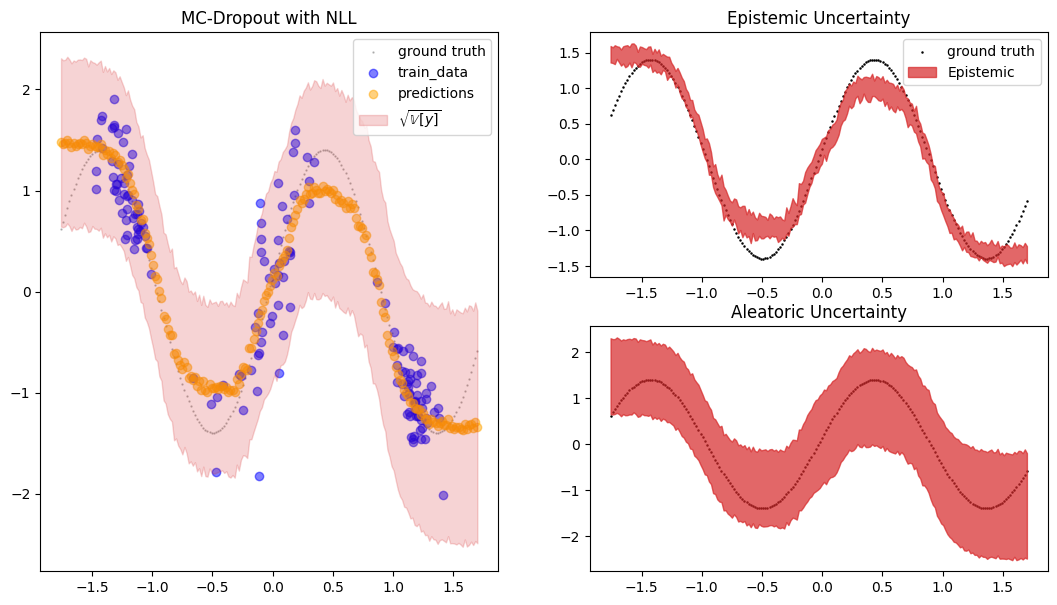

In [ ]:
# save predictions
preds = mc_dropout_module.predict_step(X_test)
preds.keys()
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="MC-Dropout with NLL",
)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         testMAE            0.30402863025665283
         testR2             0.8493224382400513
        testRMSE            0.39569681882858276
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


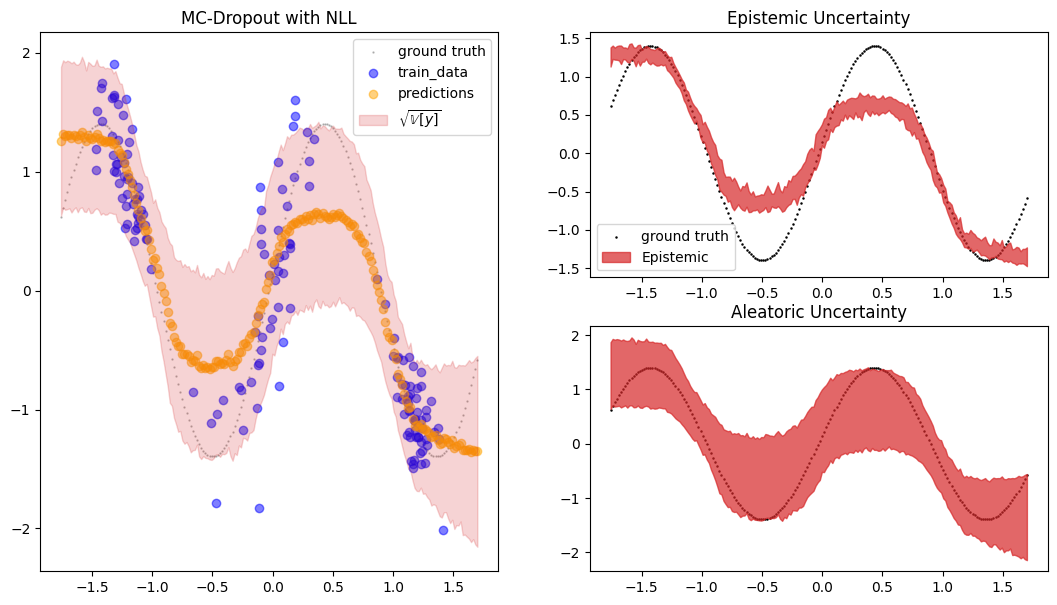

In [ ]:
# save predictions
preds = mc_dropout_module.predict_step(X_test)
preds.keys()
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="MC-Dropout with NLL",
)

In [ ]:
import os
import sys


import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DKLRegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

Seed set to 0


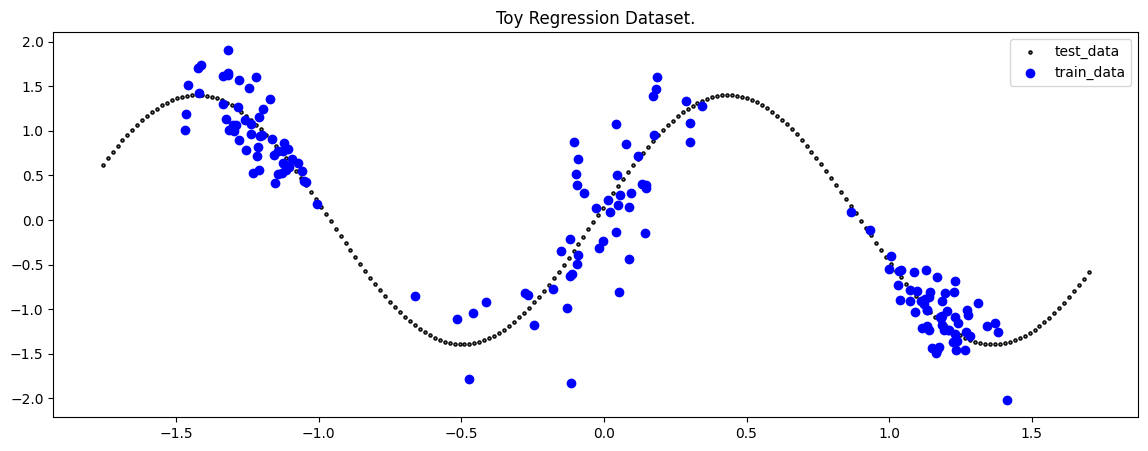

In [ ]:
seed_everything(0)  # seed everything for reproducibility
my_temp_dir = tempfile.mkdtemp()
dm = ToyHeteroscedasticDatamodule(batch_size=32)

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)
fig = plot_toy_regression_data(X_train, y_train, X_test, y_test)


In [ ]:
X_train.shape, y_train.shape

(torch.Size([160, 1]), torch.Size([160, 1]))

In [ ]:
feature_extractor = MLP(
    n_inputs=1, n_outputs=10, n_hidden=[80], activation_fn=torch.nn.ReLU()
)
dkl_model = DKLRegression(
    feature_extractor=feature_extractor,
    gp_kernel="RBF",
    optimizer=partial(torch.optim.Adam, lr=1e-3),
    n_inducing_points=40,
)
# logger = CSVLogger(my_temp_dir)
# trainer = Trainer(
#     max_epochs=100,  # number of epochs we want to train
#     logger=logger,  # log training metrics for later evaluation
#     log_every_n_steps=1,
#     enable_checkpointing=False,
#     enable_progress_bar=False,
#     default_root_dir=my_temp_dir,
# )
# trainer.fit(dkl_model, dm)


In [ ]:
dkl_model.configure_optimizers()

RuntimeError: DKLRegression is not attached to a `Trainer`.

In [ ]:
import torch
# Find optimal model hyperparameters
feature_extractor.train()
dkl_model.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(
    dkl_model.parameters(), lr=1e-3
)  # Includes GaussianLikelihood parameters

from tqdm.notebook import tqdm
bar = tqdm(range(100))
for i in bar:
    optimizer.zero_grad()
    # Zero gradients from previous iteration
    loss = dkl_model.training_step({"input": X_train, "target": y_train}, batch_idx=0)
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f"{loss.detach().cpu().item()}")

  0%|          | 0/100 [00:00<?, ?it/s]

AttributeError: 'DKLRegression' object has no attribute 'scale_to_bounds'

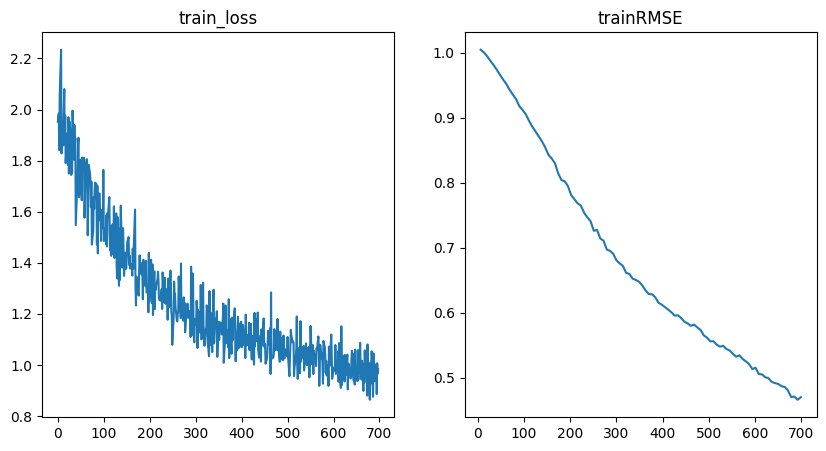

In [ ]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

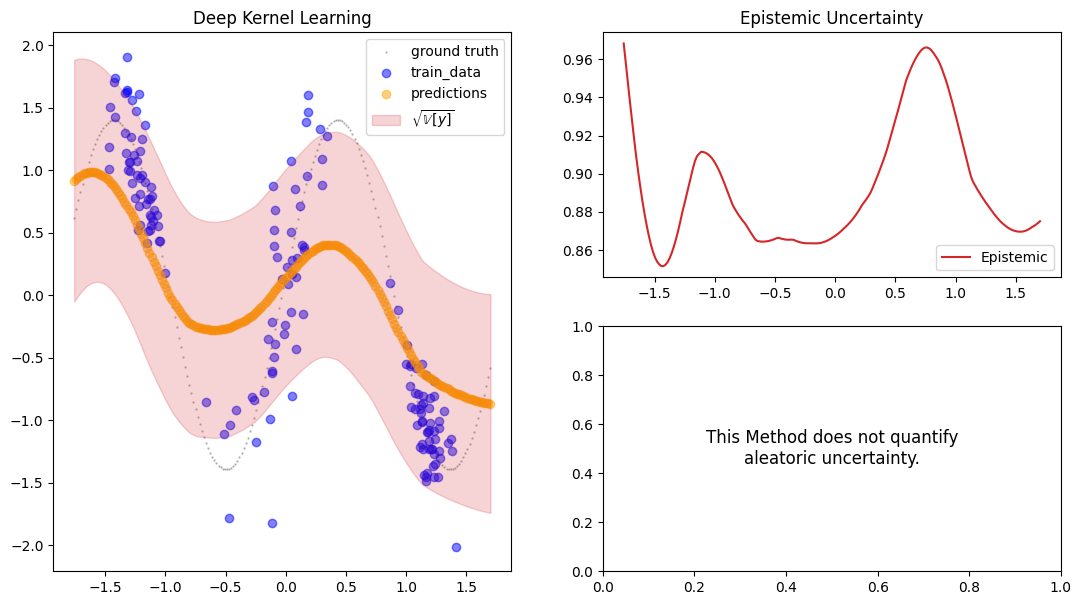

In [ ]:
preds = dkl_model.predict_step(X_test)
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    title="Deep Kernel Learning",
    show_bands=False,
)

<Figure size 1400x500 with 0 Axes>

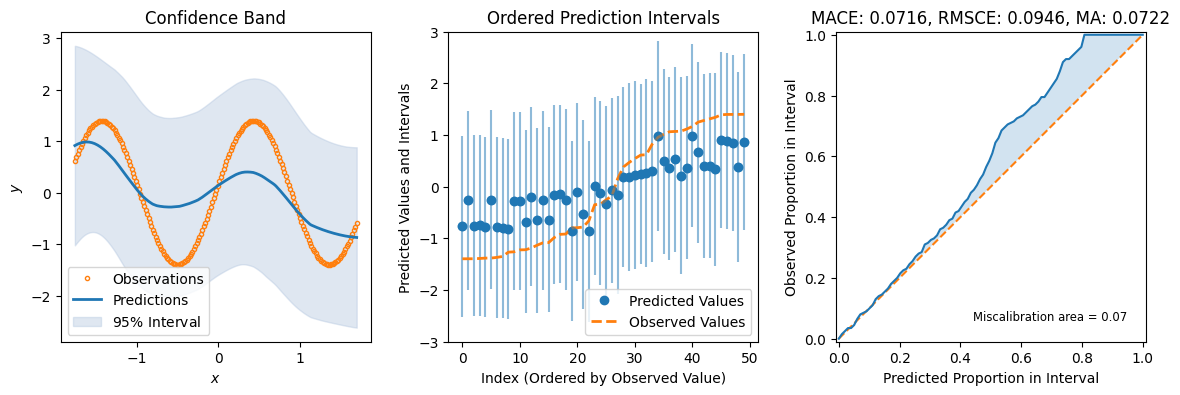

In [ ]:
fig = plot_calibration_uq_toolbox(
    preds["pred"].numpy(),
    preds["pred_uct"].numpy(),
    y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)

In [ ]:
from lightning import LightningDataModule
from torch.utils.data import DataLoader, TensorDataset

def collate_fn_tensordataset(batch):
    """Collate function for tensor dataset to our framework."""
    inputs = torch.stack([item[0] for item in batch])
    targets = torch.stack([item[1] for item in batch])
    return {"input": inputs, "target": targets}

class MyDataModule(LightningDataModule):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def train_dataloader(self):
        print('--train_dataloader')
        return DataLoader(
            TensorDataset(self.x, self.y),
            batch_size=32,
            shuffle=True,
            collate_fn=collate_fn_tensordataset,
        )

    def val_dataloader(self):
        print('--val_dataloader')
        return DataLoader(
            TensorDataset(self.x, self.y),
            batch_size=32,
            shuffle=True,
            collate_fn=collate_fn_tensordataset,
        )

    def test_dataloader(self):
        print('--test_dataloader')
        return DataLoader(
            TensorDataset(self.x, self.y),
            batch_size=32,
            shuffle=True,
            collate_fn=collate_fn_tensordataset,
        )

    def predict_dataloader(self):
        print('--predict_dataloader')
        return DataLoader(
            TensorDataset(self.x, self.y),
            batch_size=32,
            shuffle=True,
            collate_fn=collate_fn_tensordataset,
        )

    def teardown(self, stage: str):
        pass

In [ ]:
from dataset.grid import BraninDatasetHandler
# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=10,
    train_path="../data/branin/data_%i_train.csv" % 10,
    train_fraction=1.0,
    float_precision=32,
)
train_data, test_data = dataset_handler.get_dataloader()


In [ ]:
x, y = dataset_handler.train_data[:]
y = y.unsqueeze(-1)
x.shape, y.shape
my_data = MyDataModule(x, y)

In [ ]:
import os
import sys


import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DKLRegression

plt.rcParams["figure.figsize"] = [14, 5]
seed_everything(0)  # seed everything for reproducibility
my_temp_dir = tempfile.mkdtemp()

Seed set to 0


In [ ]:
feature_extractor = MLP(
    n_inputs=2, n_outputs=128, n_hidden=[32], activation_fn=torch.nn.ReLU()
)
dkl_model = DKLRegression(
    feature_extractor=feature_extractor,
    gp_kernel="RBF",
    optimizer=partial(torch.optim.Adam, lr=1e-3),
    n_inducing_points=4,
)
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=512,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)
trainer.fit(dkl_model, my_data)


/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/c/christina.humer/.conda/envs/al_new/lib/ ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmp3b2ovmum/lightning_logs

  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | MLP                | 4.3 K 
1 | train_metrics     | MetricCollection   | 0     
2 | val_metrics       | MetricCollection   | 0     
3 | test_metrics      | MetricCollection   | 0     
4 | gp_layer          | DKLGPLayer         | 535   
5 | scale_to_bounds   | ScaleToBounds      | 0     
6 | likeli

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


--train_dataloader
--val_dataloader
--train_dataloader


`Trainer.fit` stopped: `max_epochs=512` reached.


In [ ]:
preds = dkl_model.predict_step(x)
preds["pred"], preds["pred_uct"]

(tensor([-0.4301, -0.4168, -0.4111, -0.3740]),
 tensor([0.9029, 0.8991, 0.9008, 0.9803]))

In [ ]:
candidates, xi, yi = dataset_handler.get_candidate_set()
preds = dkl_model.predict_step(candidates.to(torch.float32))
preds

{'pred': tensor([-0.4315, -0.4288, -0.4259, -0.4228, -0.4195, -0.4160, -0.4124, -0.4087,
         -0.4049, -0.4018, -0.4277, -0.4249, -0.4217, -0.4183, -0.4148, -0.4112,
         -0.4074, -0.4036, -0.4009, -0.3985, -0.4235, -0.4204, -0.4171, -0.4135,
         -0.4099, -0.4061, -0.4022, -0.3997, -0.3974, -0.3957, -0.4189, -0.4157,
         -0.4122, -0.4085, -0.4047, -0.4008, -0.3984, -0.3962, -0.3939, -0.3928,
         -0.4142, -0.4106, -0.4070, -0.4032, -0.3994, -0.3971, -0.3949, -0.3926,
         -0.3911, -0.3899, -0.4093, -0.4056, -0.4017, -0.3978, -0.3958, -0.3936,
         -0.3914, -0.3893, -0.3883, -0.3869, -0.4043, -0.4005, -0.3967, -0.3947,
         -0.3924, -0.3901, -0.3878, -0.3864, -0.3853, -0.3839, -0.3990, -0.3955,
         -0.3936, -0.3915, -0.3892, -0.3867, -0.3846, -0.3836, -0.3823, -0.3808,
         -0.3941, -0.3923, -0.3904, -0.3883, -0.3860, -0.3835, -0.3822, -0.3809,
         -0.3794, -0.3787, -0.3908, -0.3890, -0.3871, -0.3849, -0.3827, -0.3809,
         -0.3801, -0

(<Figure size 1400x500 with 2 Axes>, <Axes: >)

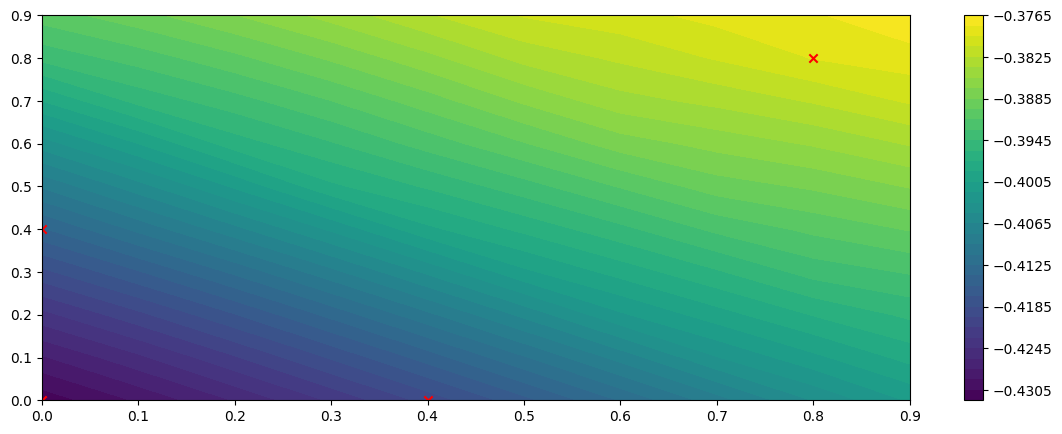

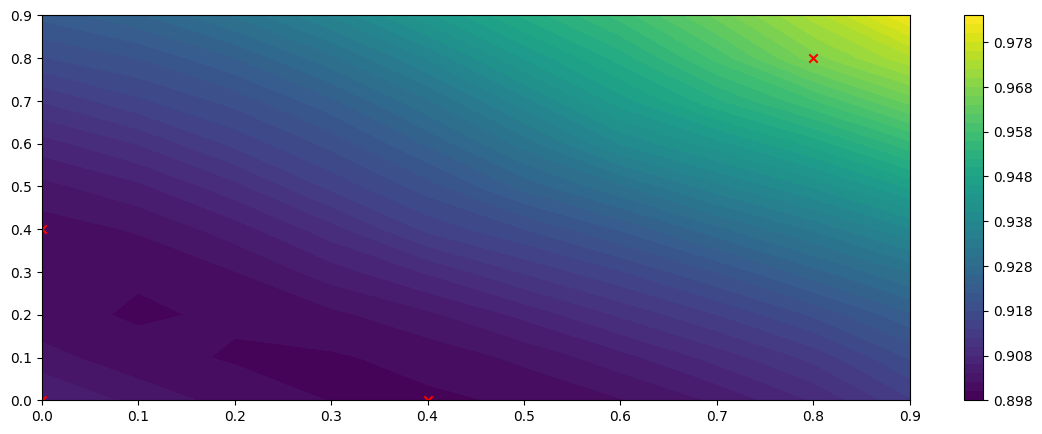

In [ ]:
from utils.plotter import PlotHelper
plot = PlotHelper()
fig, ax = plot.plot_function(dkl_model.predict_step, candidates.to(torch.float32), xi, yi, output_index="pred")
plot.plot_samples(x, fig=fig, ax=ax)
fig, ax = plot.plot_function(dkl_model.predict_step, candidates.to(torch.float32), xi, yi, output_index="pred_uct")
plot.plot_samples(x, fig=fig, ax=ax)


In [ ]:
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# initialize the likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# init the GP model
gp_model = ExactGPModel(x.squeeze(), y.squeeze()*-1, likelihood)

# Find optimal model hyperparameters
gp_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(
    gp_model.parameters(), lr=1e-2
)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

from tqdm.notebook import tqdm
bar = tqdm(range(1000))
for i in bar:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gp_model(x.squeeze())
    # Calc loss and backprop gradients
    loss = -mll(output, y.squeeze()*-1)
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f"{loss.detach().cpu().item()}")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def get_preds(x):
    gp_model.eval()
    likelihood.eval()

    with torch.no_grad():
        gp_preds = gp_model(x.cpu())

    gp_mean = gp_preds.mean.detach().cpu()
    gp_var = gp_preds.variance.detach().cpu()
    gp_covar = gp_preds.covariance_matrix.detach().cpu()

    return gp_mean, gp_var

(<Figure size 1400x500 with 2 Axes>, <Axes: >)

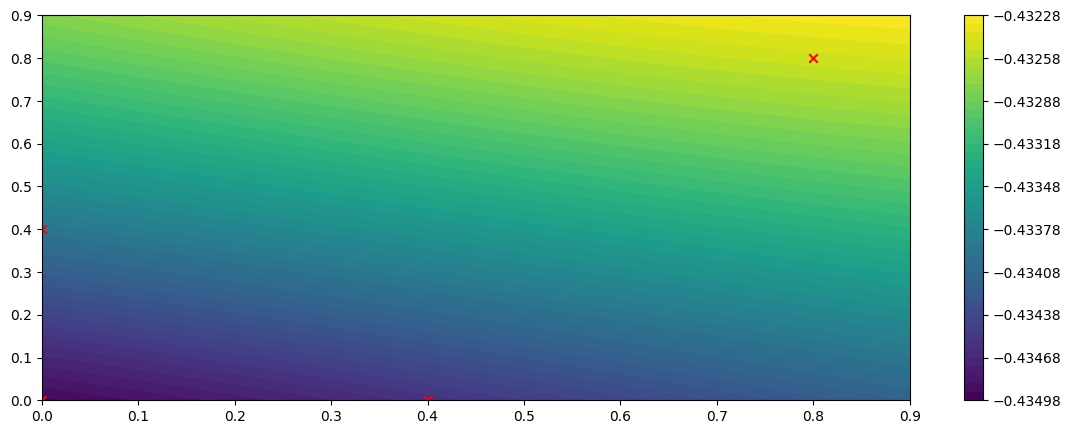

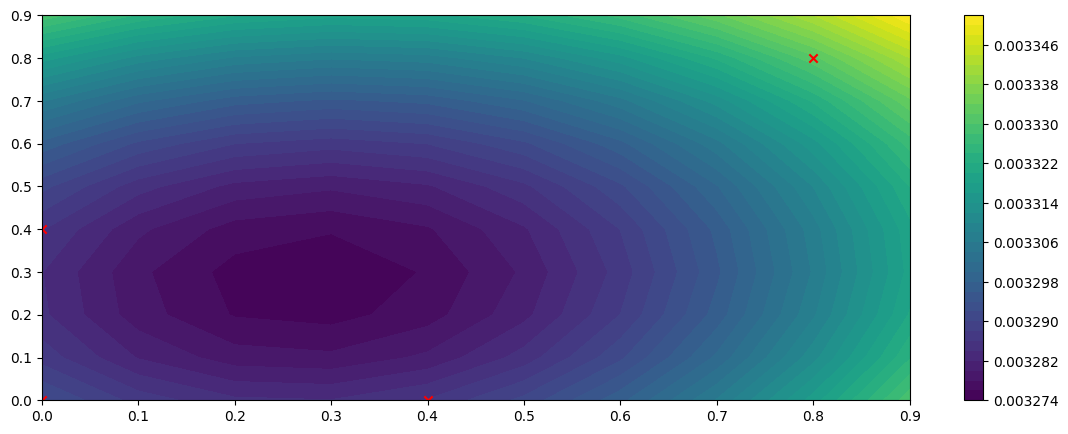

In [ ]:
from utils.plotter import PlotHelper
plot = PlotHelper()
fig, ax = plot.plot_function(get_preds, candidates.to(torch.float32), xi, yi, output_index=0)
plot.plot_samples(x, fig=fig, ax=ax)
fig, ax = plot.plot_function(get_preds, candidates.to(torch.float32), xi, yi, output_index=1)
plot.plot_samples(x, fig=fig, ax=ax)


In [ ]:
from surrogate.gp_models import SingleTaskSVGP
from surrogate.surrogate import Surrogate
from gpytorch.mlls import VariationalELBO
import torch
import copy
from torch.optim.lr_scheduler import MultiStepLR
import math
from tqdm import tqdm

from botorch.acquisition.max_value_entropy_search import (
    qLowerBoundMaxValueEntropy,
)


def check_early_stopping(
    model,
    best_score,
    best_epoch,
    best_weights,
    curr_score,
    curr_epoch,
    patience,
    tol=1e-3,
    save_weights=True,
):
    eps = 1e-6
    stop = False
    if best_score is None or (best_score - curr_score) / (abs(best_score) + eps) > tol:
        best_score, best_epoch = curr_score, curr_epoch
    elif curr_epoch - best_epoch >= patience:
        stop = True
    else:
        pass

    if best_epoch == curr_epoch and save_weights:
        del best_weights
        model.cpu()  # avoid storing two copies of the weights on GPU
        best_weights = copy.deepcopy(model.state_dict())
        model.to(model.device)

    return best_score, best_epoch, best_weights, stop


from surrogate.mlp import MLP


class DeepKernelRegressor(Surrogate):
    def __init__(
        self,
        device,
        float_precision,
        maximize=False,
        optim="adam",
        lr_sched_type="plateau",
    ):
        super().__init__(
            float_precision=float_precision, device=device, maximize=maximize
        )
        encoder = MLP(
            n_input=2, # dimension of the grid -> 6 for hartmann
            n_hid=16,
            n_layers=4,
            n_output=1,
            dropout_prob=0.1,
            activation="relu",
            beta1=0.9,
            beta2=0.999,
        )
        self.surrogate = SingleTaskSVGP(
            device=self.device,
            float_precision=self.float,
            feature_dim=16,
            out_dim=1,
            num_inducing_points=64,
            encoder=encoder,
            gp_lr=1e-3,
            enc_lr=1e-3,
            bs=64,
            num_epochs=512,
            holdout_ratio=0.1,
            early_stopping=True,
            patience=32,
            eval_period=1,
            tokenizer=None,
            max_shift=None, 
            mask_size=None,
        )

        self.optim = optim
        self.lr_sched_type = lr_sched_type

    def initialize_surrogate(self, train_dataloader):
        if (
            hasattr(self.surrogate, "init_inducing_points")
            and self.surrogate.num_inducing_points <= X_train.shape[0]
        ):
            print("\n---- initializing GP variational params ----")
            self.surrogate.eval()
            self.surrogate.requires_grad_(False)

            batch_size = self.batch_size
            num_batches = max(1, X_train.shape[0] // batch_size)
            arg_batches = torch.split(X_train, num_batches)
            init_features = torch.cat(
                [self.surrogate.get_features(batch) for batch in arg_batches]
            )

            self.surrogate.train()
            self.surrogate.init_inducing_points(init_features)
            self.surrogate.initialize_var_dist_sgpr(
                init_features,
                Y_train.to(init_features),
                noise_lb=1.0,
            )
            if self.progress:
                print("variational initialization successful")

        self.mll = VariationalELBO(
            self.surrogate.likelihood, self.surrogate.model, num_data=X_train.shape[0]
        )
        self.mll.to(self.surrogate.device)

    def gp_train_step(self, optimizer, inputs, targets, mll):
        self.surrogate.zero_grad(set_to_none=True)
        self.surrogate.clear_cache()  # possibly unnecessary
        features = self.surrogate.get_features(
            inputs.to(self.surrogate.device), self.batch_size, transform=False
        )

        dtype = features.dtype if (features.dtype is not torch.bool) else torch.float
        targets = self.surrogate.reshape_targets(targets).to(
            features.device, dtype=dtype
        )

        output = self.surrogate.forward(features)
        loss = -mll(output, targets).mean()

        loss.backward()
        optimizer.step()
        return loss

    def fit(self, train_dataloader, test_dataloader):
        select_crit_key = "test_nll"
        X_train = self.dataset.train_dataset["states"]
        Y_train = self.dataset.train_dataset["energies"]
        Y_train = self.surrogate.reshape_targets(Y_train)
        Y_train = Y_train.to(dtype=list(self.surrogate.parameters())[0].dtype)

        train_loader, test_loader = self.dataset.get_dataloader()

        print("\n---- preparing checkpoint ----")
        self.surrogate.eval()
        self.surrogate.requires_grad_(False)
        self.surrogate.set_train_data(X_train, Y_train, strict=False)
        start_metrics = {}
        start_metrics.update(self.surrogate.evaluate(test_loader))
        start_metrics["epoch"] = 0

        best_score = start_metrics.get(select_crit_key, None)
        best_score_epoch = 0
        self.surrogate.cpu()  # avoid storing two copies of the weights on GPU
        best_weights = copy.deepcopy(self.surrogate.state_dict())
        self.surrogate.to(self.surrogate.device)
        if best_score is not None and self.progress is True:
            print(f"\nstarting Test NLL: {best_score:.4f}")

        self.initialize_surrogate(X_train, Y_train)

        if hasattr(self.mll, "num_data"):
            self.mll.num_data = len(train_loader.dataset)

        best_loss, best_loss_epoch = None, 0
        stop = False

        if self.optim == "adam":
            optimizer = torch.optim.Adam(self.surrogate.param_groups)
        else:
            optimizer = torch.optim.SGD(self.surrogate.param_groups)
        if self.lr_sched_type == "plateau":
            lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=math.ceil(self.surrogate.patience / 2.0),
                threshold=1e-3,
            )
        elif self.lr_sched_type == "step":
            lr_sched = MultiStepLR(
                optimizer,
                milestones=[
                    0.25 * self.surrogate.num_epochs,
                    0.5 * self.surrogate.num_epochs,
                    0.75 * self.surrogate.num_epochs,
                ],
                gamma=0.1,
            )

        print("\n---- fitting all SVGP params ----")
        pbar = tqdm(range(1, self.surrogate.num_epochs + 1))
        for epoch_idx in pbar:

            metrics = {}
            avg_train_loss = 0.0
            avg_gp_loss = 0.0
            self.surrogate.train()

            for inputs, targets in train_loader:
                inputs = inputs.to(self.surrogate.device)
                targets = targets.to(self.surrogate.device)
                self.surrogate.requires_grad_(True)
                gp_loss = self.gp_train_step(optimizer, inputs, targets, self.mll)
                avg_train_loss += gp_loss.detach() / len(train_loader)
                avg_gp_loss += gp_loss.detach() / len(train_loader)

            lr_sched.step(avg_train_loss)

            metrics.update(
                {
                    "epoch": epoch_idx + 1,
                    "train_loss": avg_train_loss.item(),
                    "gp_loss": avg_gp_loss.item(),
                }
            )

            if (epoch_idx + 1) % self.surrogate.eval_period == 0:
                self.surrogate.requires_grad_(False)

                # update train features, use unaugmented train data for evaluation
                self.surrogate.eval()
                self.surrogate.set_train_data(X_train, Y_train, strict=False)
                metrics.update(self.surrogate.evaluate(test_loader))

            if self.progress:
                description = (
                    "Train Loss: {:.4f} | Test NLL: {:.4f} | Test RMSE {:.4f}".format(
                        avg_train_loss, metrics["test_nll"], metrics["test_rmse"]
                    )
                )
                pbar.set_description(description)

            # use validation NLL for model selection
            select_crit = metrics.get(select_crit_key, None)
            if self.surrogate.early_stopping and select_crit is not None:
                # and select_crit is not None:
                assert (
                    self.surrogate.holdout_ratio > 0.0
                ), "Need validation data for early stopping"
                best_score, best_score_epoch, best_weights, _ = check_early_stopping(
                    model=self.surrogate,
                    best_score=best_score,
                    best_epoch=best_score_epoch,
                    best_weights=best_weights,
                    curr_score=select_crit,
                    curr_epoch=epoch_idx + 1,
                    patience=self.surrogate.patience,
                    save_weights=True,
                )
            metrics.update(dict(best_score=best_score, best_epoch=best_score_epoch))

            # use train loss to determine convergence
            stop_crit_key = "test_nll"
            stop_crit = metrics.get(stop_crit_key, None)
            if stop_crit is not None:
                best_loss, best_loss_epoch, _, stop = check_early_stopping(
                    model=self.surrogate,
                    best_score=best_loss,
                    best_epoch=best_loss_epoch,
                    best_weights=None,
                    curr_score=stop_crit,
                    curr_epoch=epoch_idx + 1,
                    patience=self.surrogate.patience,
                    save_weights=False,
                )
            metrics.update(dict(best_loss=best_loss, best_loss_epoch=best_loss_epoch))

            log_prefix = "svgp"
            if len(log_prefix) > 0:
                metrics = {
                    "/".join((log_prefix, key)): val for key, val in metrics.items()
                }
            try:
                self.logger.log_metrics(metrics, use_context=True)
            except Exception:
                pass

            if stop:
                break

        if self.surrogate.early_stopping:
            print(f"\n---- loading checkpoint from epoch {best_score_epoch} ----")
            self.surrogate.load_state_dict(best_weights)
            print(f"---- best test NLL: {best_loss:.4f} ----")
            self.best_score = best_score
            self.best_loss = best_loss
        self.logger.save_proxy(
            self.surrogate, optimizer, epoch=best_score_epoch, final=True
        )
        self.surrogate.requires_grad_(False)
        self.surrogate.train()  # clear caches
        self.surrogate.clear_cache()
        self.surrogate.eval()
        self.surrogate.set_train_data(X_train, Y_train, strict=False)

    def get_predictions(self, env, states, denorm=False):
        self.surrogate.eval()
        self.surrogate.clear_cache()
        self.surrogate.requires_grad_(False)

        states_proxy_input = states.clone()
        states_proxy = env.statetorch2proxy(states_proxy_input)
        y_mean, y_std, f_std = [], [], []
        with torch.no_grad():
            for batch in range(0, len(states_proxy), 32):
                states_proxy_batch = states_proxy[batch : batch + 32]
                features = self.surrogate.get_features(
                    states_proxy_batch.to(self.device), transform=None
                )
                f_dist = self.surrogate(features)
                y_dist = self.surrogate.likelihood(f_dist)
                f_std.append(f_dist.variance.sqrt().cpu())
                y_mean.append(y_dist.mean.cpu())
                y_std.append(y_dist.variance.sqrt().cpu())
        cat_dim = 0
        f_std = torch.cat(f_std, cat_dim).view(len(states), -1)
        y_mean = torch.cat(y_mean, cat_dim).view(len(states), -1)
        y_std = torch.cat(y_std, cat_dim).view(len(states), -1)
        if denorm == True and self.dataset.normalize_data == True:
            y_mean = (
                y_mean
                * (
                    self.dataset.train_stats["max"].cpu()
                    - self.dataset.train_stats["min"].cpu()
                )
                + self.dataset.train_stats["min"].cpu()
            )
            y_mean = y_mean.squeeze(-1)
        return y_mean, y_std

    def get_acquisition_values(self, candidate_set):
        candidate_set = candidate_set.to(self.device).to(self.float)
        acqf = qLowerBoundMaxValueEntropy(
            self.surrogate,
            candidate_set=candidate_set,
        )
        return acqf(candidate_set.unsqueeze(1)).detach()

In [ ]:
# from surrogate.surrogate import DeepKernelRegressor

surrogate = DeepKernelRegressor(
    float_precision=64, device='cpu', maximize=False
)
surrogate.fit(train_data)

fig_acq, ax_acq = plotter.plot_function(surrogate, candidate_set.clone().to("cpu"), xi=xi, yi=yi)
fig_acq, ax_acq = plotter.plot_samples(sample_states, ax_acq, fig_acq)
ax_acq.set_title("SingleTaskGPRegressor acquisition fn + train samples")
plotter.log_figure(fig_acq, "acq")

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1461], dtype=torch.float64), std = tensor([1.0425], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


TypeError: DeepKernelRegressor.fit() missing 1 required positional argument: 'test_dataloader'